In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from climakitae.new_core.user_interface import ClimateData

In [2]:
cd = ClimateData()

Initializing ClimateData...


In [4]:
cd.show_processors()
cd.show_validators()

Available processors:
apply_bias_correction
apply_shape_file
convert_units
filter_data
global_warming_level
rename_variables
Available validators:


In [ ]:
data = (cd
    .catalog("renewables")
    .installation("pv_utility")
    .experiment_id("historical")
    .table_id("day")
    .grid_label("d03")
    .variable("cf")
    # .processes({
    #     "time_slice": ("2020-01-01", "2020-12-31"),
    #     "clip": ((36.04, 37.37), (-121.06, -121.43)))
    # }
    # )
    .get()
)

Error during dataset creation:
No validator registered for renewables


In [ ]:
pajaro = "/home/nschroed/Downloads/PajaroRiverWatershed.zip"


In [ ]:
pajaro = "/home/nschroed/Downloads/PajaroRiverWatershed.zip"
clip_shp = Clip(pajaro)

In [ ]:
clip_shp_data = clip_shp.execute(data, {})


TypeError: called match pattern must be a class

-121.98428 -120.50598 36.04231 37.368984


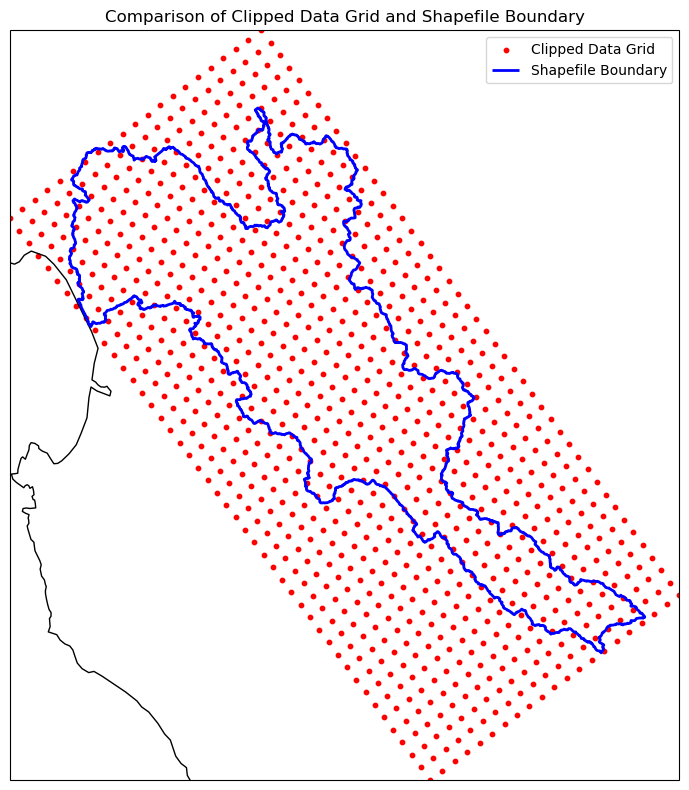

In [ ]:
# Compare the spatial extent of the clipped data (clip_shp_data) to the shapefile boundary
# Get the first dataset from the clipped data
key_shp = list(clip_shp_data.keys())[0]
ds_shp = clip_shp_data[key_shp]
ds = data[key_shp]

# Extract lat/lon from the clipped data
lon_shp = ds_shp.lon.values
lat_shp = ds_shp.lat.values

# get the x, y coordinates of the grid points
x_shp, y_shp = ds_shp.x.values, ds_shp.y.values
min_x_shp, max_x_shp = x_shp.min(), x_shp.max()
min_y_shp, max_y_shp = y_shp.min(), y_shp.max()

# convert the x, y coordinates to lat/lon
from pyproj import Transformer
transformer = Transformer.from_crs(crs_from=ds.rio.crs, crs_to="EPSG:4326")
min_lon_shp, min_lat_shp = transformer.transform(min_x_shp, min_y_shp)
max_lon_shp, max_lat_shp = transformer.transform(max_x_shp, max_y_shp)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the clipped grid points
ax.scatter(lon_shp.flatten(), lat_shp.flatten(), s=10, c='red', label='Clipped Data Grid')
print(min(lon_shp.flatten()), max(lon_shp.flatten()), min(lat_shp.flatten()), max(lat_shp.flatten()))

# Overlay the shapefile boundary
import geopandas as gpd
gdf = gpd.read_file(pajaro)
# Ensure the shapefile is in the same coordinate reference system (CRS) as the data
gdf = gdf.to_crs(epsg=4326)  # WGS 84
gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Shapefile Boundary')

# auto scale the plot
ax.set_extent([lon_shp.min(), lon_shp.max(), lat_shp.min(), lat_shp.max()], crs=ccrs.PlateCarree())
ax.coastlines()
# ax.add_feature(ccrs.feature.BORDERS, linestyle=':')
# ax.add_feature(ccrs.feature.LAND, edgecolor='black')
# ax.add_feature(ccrs.feature.OCEAN, edgecolor='black')

ax.set_title("Comparison of Clipped Data Grid and Shapefile Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Clipped Data Grid:")
print(f"Min Lon: {lon_shp.min()}, Max Lon: {lon_shp.max()}")
print(f"Min Lat: {lat_shp.min()}, Max Lat: {lat_shp.max()}")
pajaro_lat_lon = (
    (min_lon_shp, max_lon_shp),
    (min_lat_shp, max_lat_shp)
)
print(pajaro_lat_lon)

clip_lat_lon = Clip(pajaro_lat_lon)
clip_lat_lon_data = clip_lat_lon.execute(data, {})

Clipped Data Grid:
Min Lon: -121.98428344726562, Max Lon: -120.5059814453125
Min Lat: 36.04230880737305, Max Lat: 37.36898422241211
((36.04231072695839, 37.368986826011145), (-121.05667285637668, -121.42976616591216))


adding map features...


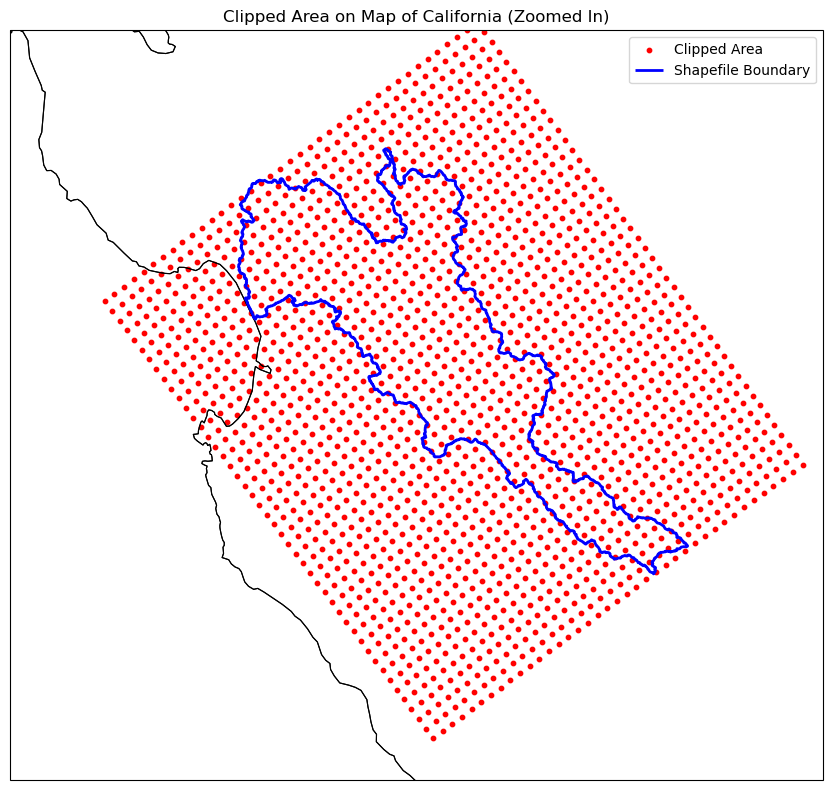

In [ ]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# plot the clipped data
import matplotlib.pyplot as plt

key = list(clip_lat_lon_data.keys())[0]
lon = clip_lat_lon_data[key].lon.values
lat = clip_lat_lon_data[key].lat.values

# Only plot the clipped region on a map of California, zoomed in
# California bounding box (zoomed in)
ca_lon_zoom = [-122.5, -120.2]
ca_lat_zoom = [35.8, 37.5]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

print("adding map features...")
ax.add_feature(cfeature.STATES.with_scale("10m"), edgecolor="black", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

ax.set_title("Clipped Area on Map of California (Zoomed In)")
ax.set_xlim(ca_lon_zoom)
ax.set_ylim(ca_lat_zoom)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Plot the clipped grid points
ax.scatter(lon.flatten(), lat.flatten(), s=10, c='red', label='Clipped Area')

# Overlay the shapefile boundary
gdf = gpd.read_file(pajaro).to_crs(epsg=4326)  # WGS 84
gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Shapefile Boundary')

ax.legend()
plt.tight_layout()
plt.show()

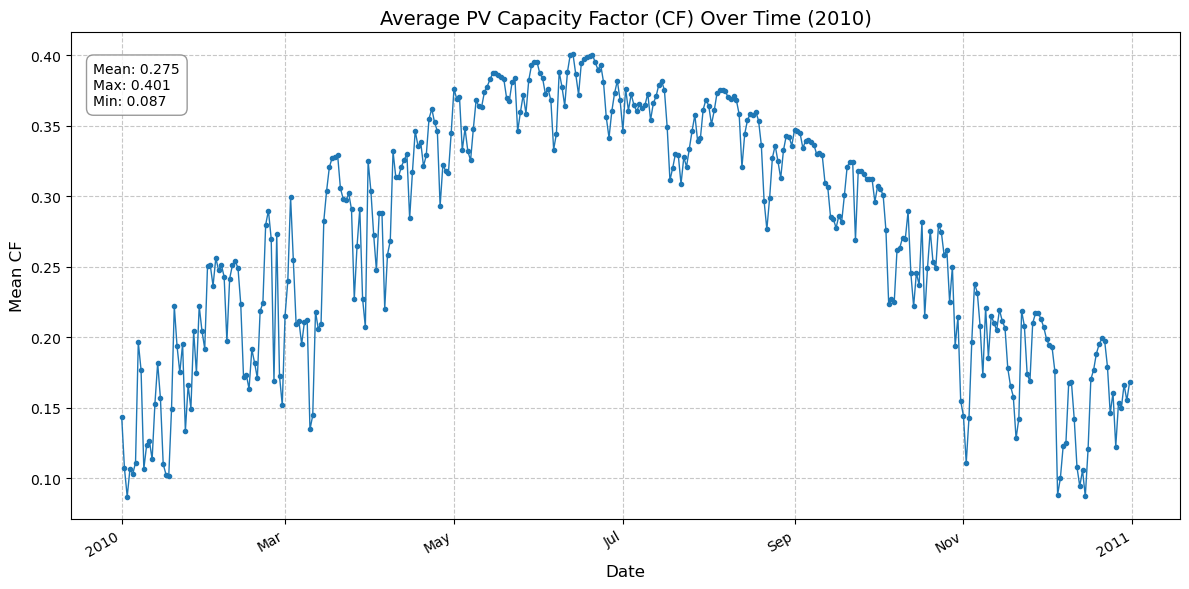

In [ ]:
# demonstrate time slicing
# Get the first dataset from the clipped data
time_range = ("2010-01-01", "2010-12-31")
time_slice = TimeSlice(time_range)
sliced_data = time_slice.execute(data, {})

key = list(sliced_data.keys())[0]
ds = data[key]
ds_sliced = sliced_data[key]

cf_time_series = ds_sliced['cf'].mean(dim=['x','y'])

# Create a time series plot
plt.figure(figsize=(12, 6))
cf_time_series.plot(marker='o', linestyle='-', linewidth=1, markersize=3)

plt.title('Average PV Capacity Factor (CF) Over Time (2010)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean CF', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format the x-axis date labels
plt.gcf().autofmt_xdate()

# Add statistics as text annotation
mean_cf = cf_time_series.mean().values
max_cf = cf_time_series.max().values
min_cf = cf_time_series.min().values

stats_text = f'Mean: {mean_cf:.3f}\nMax: {max_cf:.3f}\nMin: {min_cf:.3f}'
plt.annotate(stats_text, xy=(0.02, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()